In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# I used MMDetection framework based on torch, following their tutorial   
## https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb

## i wanted to use mmdetection of version 2. like in tutorial and mmcv 1. so i use torch <2.0

In [2]:
!pip uninstall torch --yes
!pip uninstall torch --yes

Found existing installation: torch 2.0.0
Uninstalling torch-2.0.0:
  Successfully uninstalled torch-2.0.0


In [3]:
# install dependencies: (use cu113 because has problems with cu12)
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection --branch 2.x
%cd mmdetection

!pip install -e .



Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 525.2 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 49.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 29.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1
    Uninstalling torchvision-0.15.1:
      Successfully uninstalled torchvision-0.15.1
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.1
    Uninstalling torchaudio-2.0.1:
      Successfully uninstalled torchaudio-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.12.1+cu113 which is incompatible.
Looking in links: https://download.

In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.12.1+cu113 True


/opt/conda/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


2.28.2
11.3
GCC 9.3


# Firstly, i try inference with pretrained detector to see if everything is working fine

In [5]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth \
      -O checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth


--2023-05-09 02:38:06--  https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.246.20.233, 47.246.20.230, 47.246.20.231, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|47.246.20.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167291982 (160M) [application/octet-stream]
Saving to: ‘checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth’

checkpoints/faster_ 100%[===================>] 159.54M  15.8MB/s    in 10s     

2023-05-09 02:38:17 (15.5 MB/s) - ‘checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth’ saved [167291982/167291982]



In [6]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = 'configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


load checkpoint from local path: checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth


FasterRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [7]:
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)


/kaggle/working/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


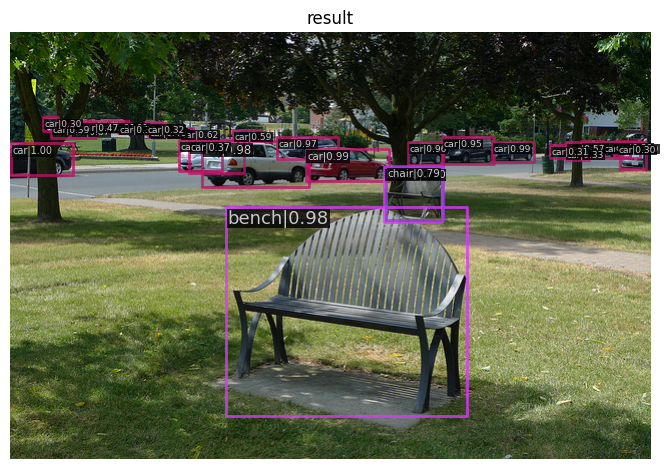

In [8]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)

In [9]:
# !apt-get -q install tree

In [10]:
# !tree /kaggle/input/rsna-pneumonia-detection-challenge

# Now we can try to train detector on pneumonia task

## i like to copy input in working directory to make it not read-only

In [11]:
%cp -r /kaggle/input/rsna-pneumonia-detection-challenge/stage_2_test_images /kaggle/working/

In [12]:
%cp -r /kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images /kaggle/working/

# Convert images from dcm to jpg format

In [ ]:
import pydicom as dicom # read dcm images from dataset
import cv2 # convert images
from tqdm import tqdm # progress bar

In [14]:
%cd /kaggle/working/stage_2_train_images

/kaggle/working/stage_2_train_images


In [15]:
for filename in tqdm(os.listdir('.')):  # train images
    ds = dicom.dcmread(filename)
    img = np.asarray(ds.pixel_array) # shape = (height, width)
    img = np.expand_dims(img, axis=0) #shape = (1,height, width)
    img = np.moveaxis(img, -1, 0) # shape = (height, 1, width)
    img = np.moveaxis(img, -1, 0) # shape = (height, width, 1) -> gray scale image array (1 channel)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # shape = (height, width, 3) -> color image array(3 channel)
    cv2.imwrite(filename[:-4]+ '.jpg', img) # save image in jpg format 

100%|██████████| 26684/26684 [11:03<00:00, 40.20it/s]


In [16]:
%rm *.dcm # removing dcm files

In [17]:
%cd /kaggle/working/stage_2_test_images

/kaggle/working/stage_2_test_images


In [18]:
for filename in tqdm(os.listdir('.')): # test images
    ds = dicom.dcmread(filename)
    img = np.asarray(ds.pixel_array) # shape = (height, width)
    img = np.expand_dims(img, axis=0) #shape = (1,height, width)
    img = np.moveaxis(img, -1, 0) # shape = (height, 1, width)
    img = np.moveaxis(img, -1, 0) # shape = (height, width, 1) -> gray scale image array (1 channel)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # shape = (height, width, 3) -> color image array(3 channel)
    cv2.imwrite(filename[:-4] + '.jpg', img) # save image in jpg format 

100%|██████████| 3000/3000 [01:12<00:00, 41.15it/s]


In [19]:
%rm *.dcm

## Quick look on a image from the dataset

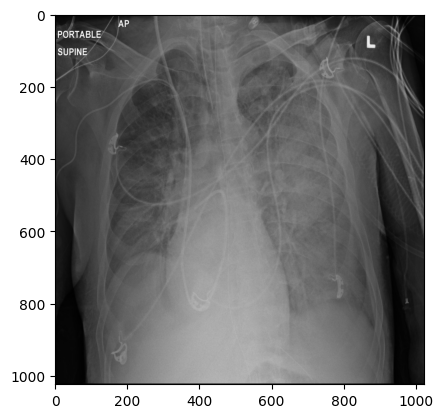

In [75]:
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('/kaggle/working/stage_2_train_images/e65d66fe-2835-4e27-859b-a65065758cab.jpg')
plt.imshow(img)
plt.show()


In [76]:
img.shape # image shape

(1024, 1024, 3)

In [ ]:
!cat /kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv # if you want to see labels

In [21]:
len(os.listdir('/kaggle/working/stage_2_train_images'))

26684

In [22]:
%cd /kaggle/working

/kaggle/working


# Convert labels format to coco, it helps to simplify next steps with configuration

### With help of this paper:   
https://medium.com/analytics-vidhya/how-to-convert-tensorflow-object-detection-csv-data-to-coco-json-format-d0693d5b2f75

In [109]:
import numpy as np
import json
import pandas as pd

path = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv' # the path to the CSV file
save_json_path = 'labels.json'


data = pd.read_csv(path)

images = []
categories = []
annotations = []

category = {}
category["supercategory"] = 'none'
category["id"] = 0
category["name"] = 'None'
categories.append(category)

data['fileid'] = data['patientId'].astype('category').cat.codes
data['categoryid']= pd.Categorical(data['Target'],ordered= True).codes
data['categoryid'] = data['categoryid']+1
data['annid'] = data.index

def image(row):
    image = {}
    image["height"] = 1024
    image["width"] = 1024
    image["id"] = row.fileid
    image["file_name"] = row.patientId + '.jpg'
    return image

def category(row):
    category = {}
    category["supercategory"] = 'None'
    category["id"] = row.categoryid
    category["name"] = row[6] # 6 column is the Target
    return category

def annotation(row):
    annotation = {}
    area = (row.width)*(row.height)
    annotation["segmentation"] = []
    annotation["iscrowd"] = 0
    annotation["area"] = area
    annotation["image_id"] = row.fileid

    annotation["bbox"] = [row.x, row.y, row.width,row.height]

    annotation["category_id"] = row.categoryid
    annotation["id"] = row.annid
    return annotation

for row in data.itertuples():
    annotations.append(annotation(row))

imagedf = data.drop_duplicates(subset=['fileid']).sort_values(by='fileid')
for row in imagedf.itertuples():
    images.append(image(row))

catdf = data.drop_duplicates(subset=['categoryid']).sort_values(by='categoryid')
for row in catdf.itertuples():
    categories.append(category(row))

data_coco = {}
data_coco["images"] = images
data_coco["categories"] = categories
data_coco["annotations"] = annotations


json.dump(data_coco, open(save_json_path, "w"), indent=4)

In [110]:
row

Pandas(Index=4, patientId='00436515-870c-4b36-a041-de91049b9ab4', x=264.0, y=152.0, width=213.0, height=379.0, Target=1, fileid=16, categoryid=2, annid=4)

# I decided to split train data json to train, valid and test for a natural use in a config, but you can split only to train/valid, because we have test images in dataset in additional directory and really use only train and val 

In [111]:
!pip install echo1-coco-split

In [112]:
%cd /kaggle/working/

/kaggle/working


In [113]:
%rm train.json
%rm test.json
%rm valid.json

In [114]:
!coco-split \
    --has_annotations \
    --valid_ratio .2 \
    --test_ratio .1 \
    --annotations_file /kaggle/working/labels.json

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Saved 21157 annotations from 18678 images to train.json
Saved 6040 annotations from 5337 images to valid.json
Saved 3030 annotations from 2669 images to test.json


# Load existing config and edit it

In [158]:
from mmcv import Config
cfg = Config.fromfile('/kaggle/working/mmdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

In [67]:
cfg.keys()

dict_keys(['model', 'dataset_type', 'data_root', 'img_norm_cfg', 'train_pipeline', 'test_pipeline', 'data', 'evaluation', 'optimizer', 'optimizer_config', 'lr_config', 'runner', 'checkpoint_config', 'log_config', 'custom_hooks', 'dist_params', 'log_level', 'load_from', 'resume_from', 'workflow', 'opencv_num_threads', 'mp_start_method', 'auto_scale_lr'])

In [180]:
from mmdet.apis import set_random_seed
# Modify dataset type and path
cfg.dataset_type = 'CocoDataset'
cfg.data_root = '/kaggle/working/'
cfg.device = 'cuda'
classes = (0,1,) # 

cfg.data.test.type = 'CocoDataset'
cfg.data.test.classes = classes
cfg.data.test.data_root = '/kaggle/working/stage_2_train_images'
cfg.data.test.ann_file = '/kaggle/working/test.json'
cfg.data.test.img_prefix = ''

cfg.data.train.type = 'CocoDataset'
cfg.data.train.classes = classes
cfg.data.train.data_root = '/kaggle/working/stage_2_train_images'
cfg.data.train.ann_file = '/kaggle/working/train.json'
cfg.data.train.img_prefix = ''


cfg.data.val.type = 'CocoDataset'
cfg.data.val.classes = classes
cfg.data.val.data_root = '/kaggle/working/stage_2_train_images'
cfg.data.val.ann_file = '/kaggle/working/valid.json'
cfg.data.val.img_prefix = ''

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 2
# If we need to finetune a model based on a pre-trained detector, we need to
# use load_from to set the path of checkpoints.
cfg.load_from = '/kaggle/working/mmdetection/checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/kaggle/working/logs_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'bbox'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 1


# I will train for 2 epochs to get fast result
cfg.runner.max_epochs = 2

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cro

# Now we can build detector to train

In [181]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
import os.path as osp



# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
classes = ('nothing', 'pneumonia')
model.CLASSES = classes





loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


### quick check if dataset load went wrong

In [182]:
print(datasets)

[
CocoDataset Train dataset with number of images 18678, and instance counts: 
+----------+-------+----------+-------+---------------+-------+----------+-------+----------+-------+
| category | count | category | count | category      | count | category | count | category | count |
+----------+-------+----------+-------+---------------+-------+----------+-------+----------+-------+
|          |       |          |       |               |       |          |       |          |       |
| 0 [0]    | 0     | 1 [1]    | 6708  | -1 background | 14449 |          |       |          |       |
+----------+-------+----------+-------+---------------+-------+----------+-------+----------+-------+]


In [183]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# Train
train_detector(model, datasets, cfg, distributed=False, validate=True)

2023-05-09 10:09:28,278 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2023-05-09 10:09:28,336 - mmdet - INFO - load checkpoint from local path: /kaggle/working/mmdetection/checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


2023-05-09 10:09:28,487 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([3, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([8, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([8]).
2023-05-09 10:09:28,493 - mmdet - INFO - Start running, host: root@a56b29b27485, work_dir: /kaggle/working/logs_exps
2023-05-09 10:09:28,495 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUp

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 5337/5337, 16.2 task/s, elapsed: 330s, ETA:     0s

2023-05-09 10:48:01,370 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.27s).
Accumulating evaluation results...


2023-05-09 10:48:04,675 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.196
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.070
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.193
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.193
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.193
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.89s).


2023-05-09 10:48:09,355 - mmdet - INFO - Epoch [2][10/9339]	lr: 2.500e-03, eta: 0:32:58, time: 0.449, data_time: 0.242, memory: 3636, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0013, loss_cls: 0.0458, acc: 98.2617, loss_bbox: 0.0403, loss: 0.0896
2023-05-09 10:48:11,397 - mmdet - INFO - Epoch [2][20/9339]	lr: 2.500e-03, eta: 0:32:56, time: 0.205, data_time: 0.016, memory: 3636, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0025, loss_cls: 0.0383, acc: 98.3691, loss_bbox: 0.0529, loss: 0.0961
2023-05-09 10:48:13,484 - mmdet - INFO - Epoch [2][30/9339]	lr: 2.500e-03, eta: 0:32:54, time: 0.208, data_time: 0.015, memory: 3636, loss_rpn_cls: 0.0037, loss_rpn_bbox: 0.0046, loss_cls: 0.0390, acc: 98.5840, loss_bbox: 0.0469, loss: 0.0942
2023-05-09 10:48:15,664 - mmdet - INFO - Epoch [2][40/9339]	lr: 2.500e-03, eta: 0:32:51, time: 0.218, data_time: 0.018, memory: 3636, loss_rpn_cls: 0.0072, loss_rpn_bbox: 0.0040, loss_cls: 0.0698, acc: 97.8027, loss_bbox: 0.0738, loss: 0.1549
2023-05-09 10:48:17,805 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 5337/5337, 16.1 task/s, elapsed: 331s, ETA:     0s

2023-05-09 11:26:54,936 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.80s).
Accumulating evaluation results...


2023-05-09 11:26:58,244 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.205
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.068
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.185
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.185
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.185
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.64s).


# Test (on 5 epochs, from previous session)

## Pneumonia image 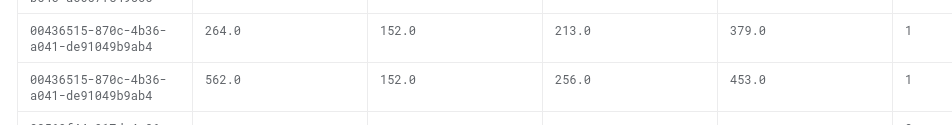

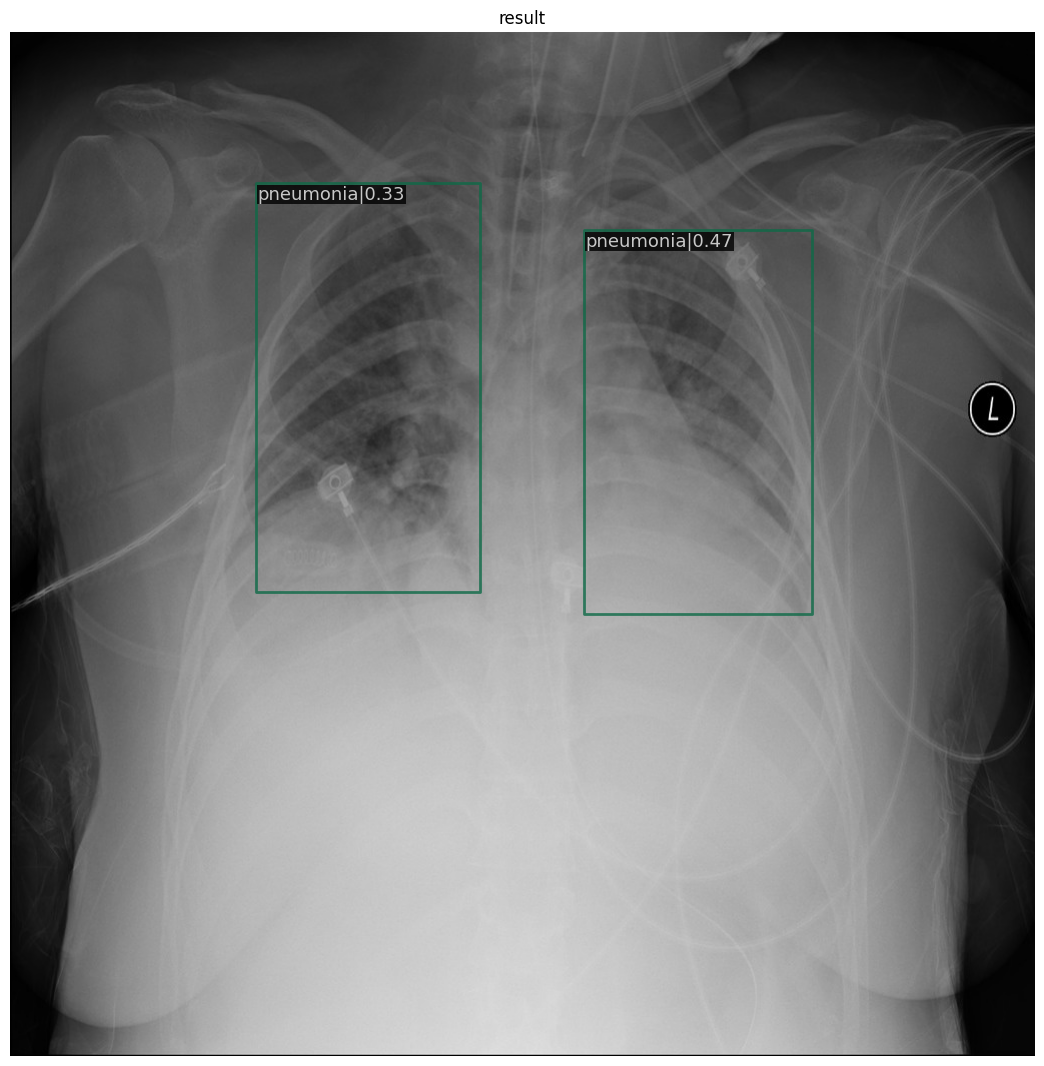

In [166]:
img = mmcv.imread('/kaggle/working/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.jpg')
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

## non-pneumonia 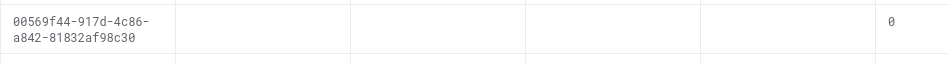

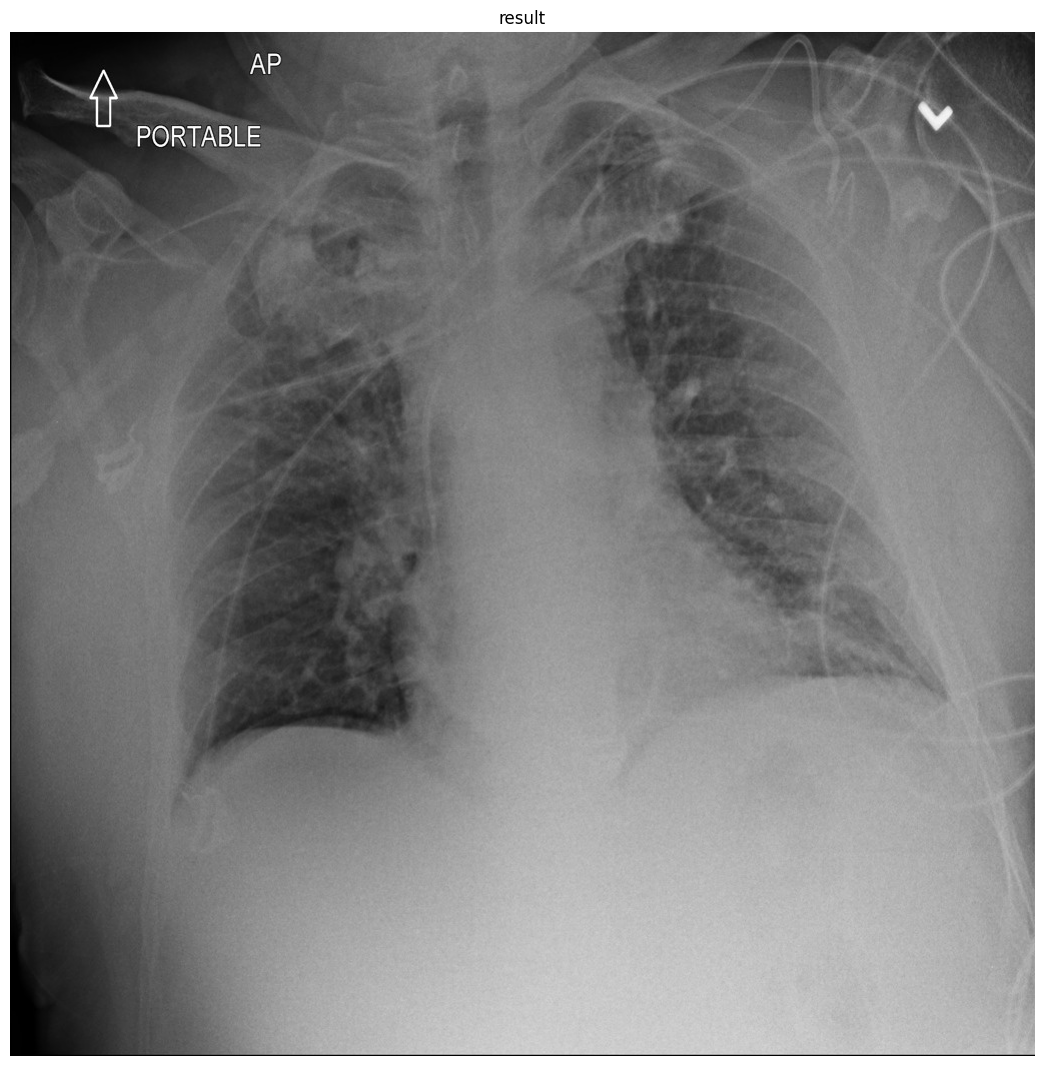

In [165]:
img3 = mmcv.imread('/kaggle/working/stage_2_train_images/00569f44-917d-4c86-a842-81832af98c30.jpg')
result = inference_detector(model, img3)
show_result_pyplot(model, img3, result)

## Now pneumonia image from test.json: 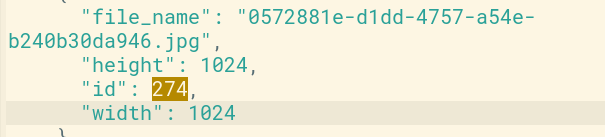 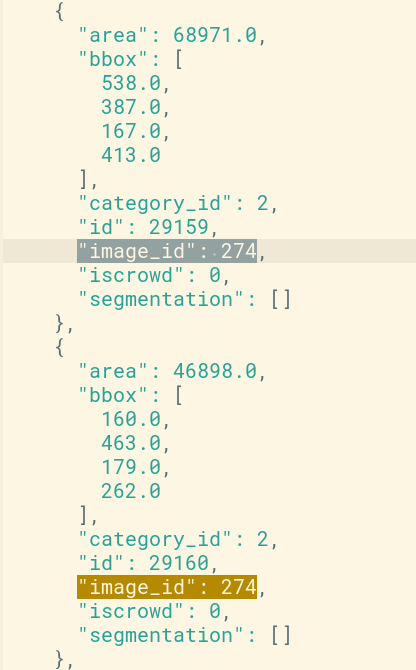

In [167]:
img4 = mmcv.imread('/kaggle/working/stage_2_train_images/0572881e-d1dd-4757-a54e-b240b30da946.jpg') # from test.json
result = inference_detector(model, img4)
show_result_pyplot(model, img4, result)

## non-pneumonia image from test.json 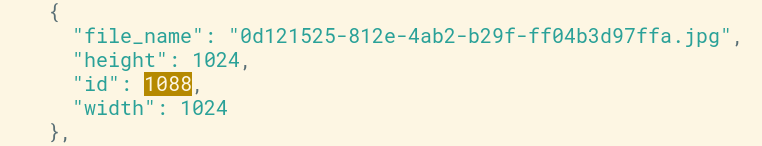 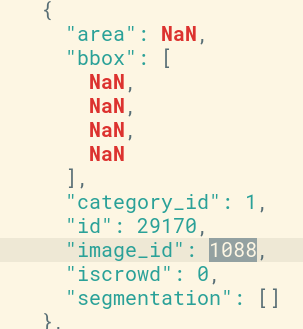

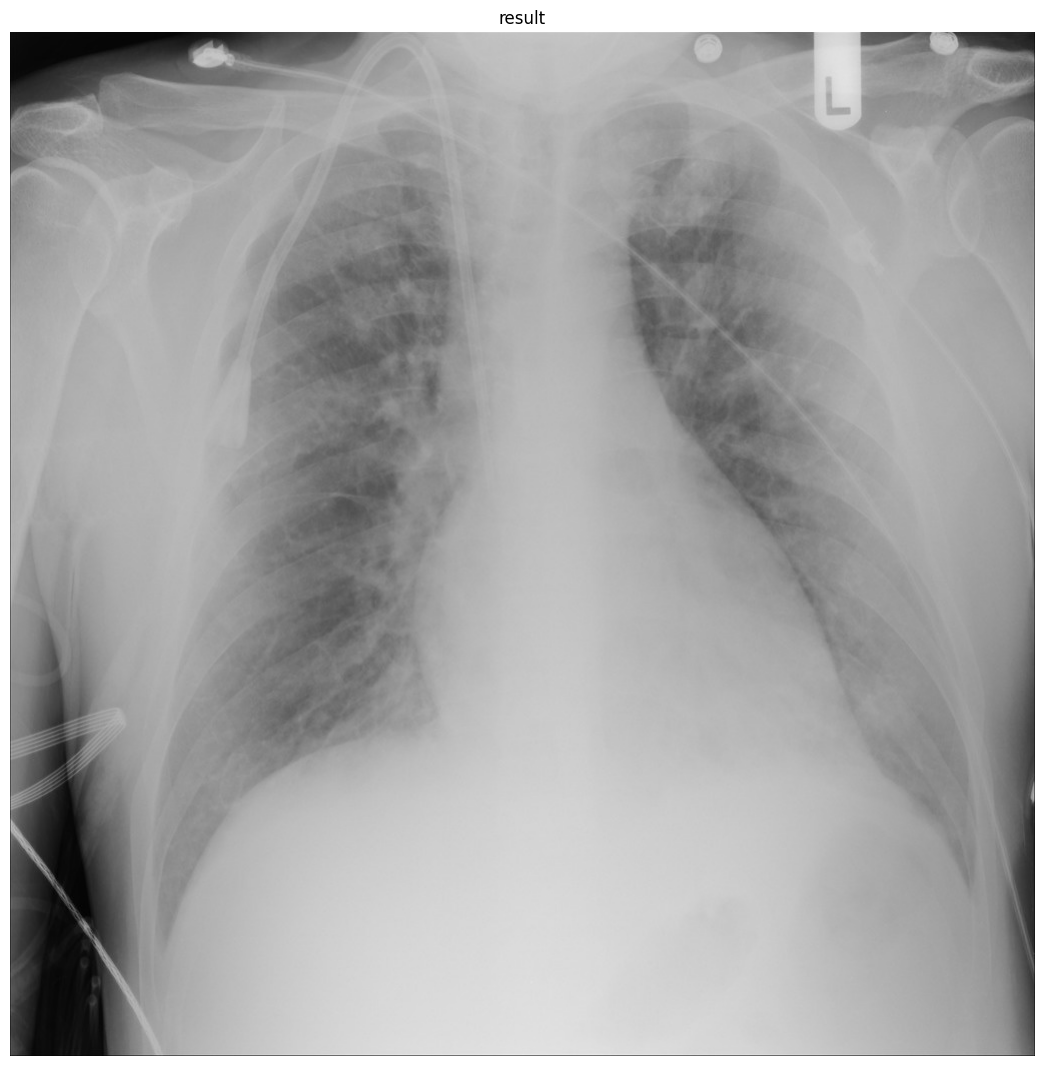

In [168]:
img5 = mmcv.imread('/kaggle/working/stage_2_train_images/0d121525-812e-4ab2-b29f-ff04b3d97ffa.jpg') # from test.json
result = inference_detector(model, img5)
show_result_pyplot(model, img5, result)
